In [ ]:
**This notebook has been prepared by Pr Fabien Moutarde and Dr Guillaume Devineau from the Center for Robotics of MINES Paris PSL.**

It adapts/combines 2 notebooks from : http://online.cambridgecoding.com/notebooks/cca_admin/deep-learning-for-complete-beginners-recognising-handwritten-digits
http://online.cambridgecoding.com/notebooks/cca_admin/convolutional-neural-networks-with-keras

**NOTE: If you try to execute this notebook on Google COLAB (https://colab.research.google.com/notebooks/welcome.ipynb)**, you should: 1/ make sure that you are using python3 and a *GPU accelerated backend* (select *GPU* as Hardware accelerator either in the *Edit > Notebook settings* or in the *Runtime > Change runtime type* menus for the english colab interface, or in the *Execution > Modifier le type d'exécution* menus for the french colab interface); 2/ modify the Force_CPU to False in one of the first code block

# Deep-Learning: Introduction to Convolutional Neural Networks

## 1. Introduction

Welcome to a tutorial to get you quickly up to speed with *deep learning*; from first principles, all the way to discussions of some of the intricate details, with the purposes of achieving respectable performance on one established machine learning benchmark: [MNIST](http://yann.lecun.com/exdb/mnist/) (classification of handwritten digits).


MNIST dataset                      
![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/mnist.png)  

By the end of this part of the tutorial, you should be capable of understanding and producing a simple CNN (with a structure similar to LeNet architecture) in Keras, achieving a respectable level of accuracy on MNIST.


## 2. Convolutions

It turns out that there is a very efficient way of pulling this off, and it makes advantage of the structure of the information encoded within an image---it is assumed that pixels that are spatially *closer* together will "cooperate" on forming a particular feature of interest much more than ones on opposite corners of the image. Also, if a particular (smaller) feature is found to be of great importance when defining an image's label, it will be equally important if this feature was found anywhere within the image, regardless of location.

Enter the **convolution** operator. Given a two-dimensional image, $\bf I$, and a small matrix, $\bf K$ of size $h \times w$, (known as a *convolution kernel*), which we assume encodes a way of extracting an interesting image feature, we compute the convolved image, ${\bf I} * {\bf K}$, by overlaying the kernel on top of the image in all possible ways, and recording the sum of elementwise products between the image and the kernel:

$$({\bf I} * {\bf K})_{xy} = \sum_{i=1}^h \sum_{j=1}^w {{\bf K}_{ij} \cdot {\bf I}_{x + i - 1, y + j - 1}}$$

(in fact, the exact definition would require us to flip the kernel matrix first, but for the purposes of machine learning it is irrelevant whether this is done)

The images below show a diagrammatical overview of the above formula and the result of applying convolution (with two separate kernels) over an image, to act as an edge detector:

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/convolve.png)
![](http://people.minesparis.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/lena.jpg)

## 3. Convolutional layers and Pooling layers

The convolution operator forms the fundamental basis of the **convolutional** layer of a CNN. The layer is completely specified by a certain number of kernels, $\bf \vec{K}$ (along with additive biases, $\vec{b}$, per each kernel), and it operates by computing the convolution of the output images of a previous layer with each of those kernels, afterwards adding the biases (one per each output image). Finally, an activation function, $\sigma$, may be applied to all of the pixels of the output images. Typically, the input to a convolutional layer will have $d$ *channels* (e.g. red/green/blue in the input layer), in which case the kernels are extended to have this number of channels as well, making the final formula of a single output image channel of a convolutional layer (for a kernel ${\bf K}$ and bias $b$) as follows:

$$\mathrm{conv}({\bf I}, {\bf K})_{xy} = \sigma\left(b + \sum_{i=1}^h \sum_{j=1}^w \sum_{k=1}^d {{\bf K}_{ijk} \cdot {\bf I}_{x + i - 1, y + j - 1, k}}\right)$$

Note that, since all we're doing here is addition and scaling of the input pixels, the kernels may be learned from a given training dataset via *gradient descent*, exactly as the weights of an MLP. In fact, an MLP is perfectly capable of replicating a convolutional layer, but it would require a lot more training time (and data) to learn to approximate that mode of operation.

Finally, let's just note that a convolutional operator is in no way restricted to two-dimensionally structured data: in fact, most machine learning frameworks ([Keras included](https://keras.io/layers/convolutional/)) will provide you with out-of-the-box layers for 1D and 3D convolutions as well!

It is important to note that, while a convolutional layer significantly decreases the number of *parameters* compared to a fully connected (FC) layer, it introduces more **hyperparameters**---parameters whose values need to be chosen *before* training starts.

Namely, the hyperparameters to choose within a single convolutional layer are:
- *depth*: how many different kernels (and biases) will be convolved with the output of the previous layer;
- *height* and *width* of each kernel;
- *stride*: by how much we shift the kernel in each step to compute the next pixel in the result. This specifies the overlap between individual output pixels, and typically it is set to $1$, corresponding to the formula given before. Note that larger strides result in smaller output sizes.
- *padding*: note that convolution by any kernel larger than $1\times 1$ will *decrease* the output image size---it is often desirable to keep sizes the same, in which case the image is sufficiently padded with zeroes at the edges. This is often called *"same"* padding, as opposed to *"valid"* (no) padding. It is possible to add arbitrary levels of padding, but typically the padding of choice will be either same or valid.

As already hinted, convolutions are not typically meant to be the sole operation in a CNN (although there have been promising recent developments on [all-convolutional networks](https://arxiv.org/pdf/1412.6806v3.pdf)); but rather to extract useful features of an image prior to downsampling it sufficiently to be manageable by an MLP.

A very popular approach to downsampling is a *pooling* layer, which consumes small and (usually) disjoint chunks of the image (typically $2\times 2$) and aggregates them into a single value. There are several possible schemes for the aggregation---the most popular being **max-pooling**, where the maximum pixel value within each chunk is taken. A diagrammatical illustration of $2\times 2$ max-pooling is given below.

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/pool.png)

## 4. Convolutional Neural Network (CNN) architecture

Now that we got all the building blocks, let's see what a typical convolutional neural network might look like!

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/cnn.png)

A typical CNN architecture for a $k$-class image classification can be split into two distinct parts---a chain of repeating $\mathrm{Conv}\rightarrow\mathrm{Pool}$ layers (sometimes with more than one convolutional layer at once), followed by a few fully connected layers (taking each pixel of the computed images as an independent input), culminating in a $k$-way softmax layer, to which a cross-entropy loss is optimised. I did not draw the activation functions here to make the sketch clearer, but do keep in mind that typically after every convolutional or fully connected layer, an activation (e.g. ReLU) will be applied to all of the outputs.

Note the effect of a single $\mathrm{Conv}\rightarrow\mathrm{Pool}$ pass through the image: it reduces height and width of the individual channels in favour of their number, i.e. *depth*.

The softmax layer and cross-entropy loss are both introduced in more detail [in the previous tutorial](http://online.cambridgecoding.com/notebooks/cca_admin/deep-learning-for-complete-beginners-recognising-handwritten-digits). For summarisation purposes, a softmax layer's purpose is converting any vector of real numbers into a vector of *probabilities* (nonnegative real values that add up to 1). Within this context, the probabilities correspond to the likelihoods that an input image is a member of a particular class. Minimising the cross-entropy loss has the effect of maximising the model's confidence in the *correct* class, without being concerned for the probabilites for other classes---this makes it a more suitable choice for probabilistic tasks compared to, for example, the squared error loss.

## 5. Detour: Overfitting, regularisation and dropout

This will be the first (and hopefully the only) time when I will divert your attention to a seemingly unrelated topic. It regards a very important pitfall of machine learning---**overfitting** a model to the training data. While this is primarily going to be a major topic of the next tutorial in the series, the negative effects of overfitting will tend to become quite noticeable on the networks like the one we are about to build, and we need to introduce a way to properly protect ourselves against it, before going any further. Luckily, there is a very simple technique we can use.

Overfitting corresponds to adapting our model to the training set to such extremes that its generalisation potential (performance on samples outside of the training set) is *severely* limited. In other words, our model might have learned the training set (along with any noise present within it) perfectly, but it has failed to capture the underlying process that generated it. To illustrate, consider a problem of fitting a sine curve, with white additive noise applied to the data points:

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/plotsin.png)

Here we have a training set (denoted by blue circles) derived from the original sine wave, along with some noise. If we fit a degree-3 polynomial to this data, we get a fairly good approximation to the original curve. Someone might argue that a degree-14 polynomial would do better; indeed, given we have 15 points, such a fit would *perfectly* describe the training data. However, in this case, the additional parameters of the model cause catastrophic results: to cope with the inherent noise of the data, anywhere except in the closest vicinity of the training points, our fit is completely off.

Deep convolutional neural networks have a large number of parameters, especially in the fully connected layers. Overfitting might often manifest in the following form: if we don't have sufficiently many training examples, a small group of neurons might become responsible for doing most of the processing and other neurons becoming redundant; or in the other extreme, some neurons might actually become detrimental to performance, with several other neurons of their layer ending up doing nothing else but correcting for their errors.

To help our models generalise better in these circumstances, we introduce techniques of *regularisation*: rather than reducing the number of parameters, we impose *constraints* on the model parameters during training to keep them from learning the noise in the training data. The particular method I will introduce here is **dropout**---a technique that initially might seem like "dark magic", but actually helps to eliminate exactly the failure modes described above. Namely, dropout with parameter $p$ will, within a single training iteration, go through all neurons in a particular layer and, with probability $p$, *completely eliminate them from the network throughout the iteration*. This has the effect of forcing the neural network to cope with *failures*, and not to rely on existence of a particular neuron (or set of neurons)---relying more on a *consensus* of several neurons within a layer. This is a very simple technique that works quite well already for combatting overfitting on its own, without introducing further regularisers. An illustration is given below.

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/drop.png)

## 6. Applying a deep CNN to MNIST

As this post's objective, we will implement a deep convolutional neural network---and apply it on the MNIST digit recognition classification task.


As already mentioned, a CNN will typically have more hyperparameters than an MLP. For the purposes of this tutorial, we will also stick to "sensible" hand-picked values for them, but do still keep in mind that later on I will introduce a more proper method for learning them.

The hyperparameters are:
- The *batch size*, representing the number of training examples being used simultaneously during a single iteration of the gradient descent algorithm;
- The number of *epochs*, representing the number of times the training algorithm will iterate over the entire training set before terminating\*;
- The *kernel sizes* in the convolutional layers;
- The *pooling size* in the pooling layers;
- The *number of kernels* in the convolutional layers;
- The *dropout probability* (we will apply dropout after each pooling, and after the fully connected layer);
- The *number of neurons* in the fully connected layer of the MLP.

\* **N.B. here I have set the number of epochs to 100, which might be undesirably slow if you do not have a GPU at your disposal (the convolution layers are going to pose a significant performance bottleneck in this case). You might wish to decrease the epoch count and/or numbers of kernels if you are going to be training the network on a CPU.**


Modelling time! Our network has an architecture similar to LeNet5 of LeCun (see figure below). It will consist of two consecutive groups of one `Convolution2D` followed by  a `MaxPooling2D` layer. After the first pooling layer, the number of kernels is rougly doubled (in line with the previously mentioned principle of sacrificing height and width for more depth). Afterwards, the output of the second pooling layer is flattened to 1D (via the `Flatten` layer), and passed through one or two fully connected (`Dense`) layers. ReLU activations will once again be used for all layers except the output dense layer, which will use a softmax activation (for purposes of probabilistic classification).

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/lenet5.png)

To regularise our model, a `Dropout` layer is applied after each pooling layer, and after the first `Dense` layer. This is another area where Keras shines compared to other frameworks: it has an internal flag that automatically enables or disables dropout, depending on whether the model is currently used for training or testing.

The remainder of the model specification is the following:
- We use the *cross-entropy* loss function as the objective to optimise (as its derivation is more appropriate for probabilistic tasks);
- We use the [*Adam* optimiser for gradient descent](http://sebastianruder.com/optimizing-gradient-descent/);
- We report the *accuracy* of the model (as the dataset is balanced across the ten classes)\*;
- We hold out 10% of the data for validation purposes.

\* To get a feeling for why accuracy might be inappropriate for unbalanced datasets, consider an extreme case where 90% of the test data belongs to class $x$ (this could be, for example, the task of diagnosing patients for an extremely rare disease). In this case, a classifier that just outputs $x$ achieves a seemingly impressive accuracy of 90% on the test data, without really doing any learning/generalisation.

This model, possibly after some tweaking of its architectural parameters, should be able to break $99\%$ accuracy on its **test set** with little to no effort.


## 7. Conclusion

Throughout this post we have covered the essentials of convolutional neural networks, introduced the problem of overfitting, and made a very brief dent into how it could be rectified via regularisation (by applying dropout) and successfully implemented a two-layer deep CNN (with LeNet like architecture) in Keras, applying it to MNIST, all in under 50 lines of code.


## 8. Just show me the code!

This code assume your already have installed <code>numpy</code>, <code>keras</code>, <code>tensorflow</code>, ... on your computer. If not, uncomment the adequate lines in the cell below:

In [1]:
import sys
print('Your python version: {}'.format(sys.version_info.major))
# Uncomment lines below only if you need them
#!{sys.executable} -m pip install -U numpy --user
#!{sys.executable} -m pip install -U matplotlib --user
#  
#!{sys.executable} -m pip install -U tensorflow --user
# OR (if in China, for faster download)
#!{sys.executable} -m pip install -U tensorflow --user -i https://pypi.tuna.tsinghua.edu.cn/simple

Your python version: 3


In [3]:

import tensorflow
print('Your tensorflow version: {}'.format(tensorflow.__version__))
print("GPU : "+tensorflow.test.gpu_device_name())


2024-10-15 16:22:21.391876: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 16:22:21.404735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 16:22:21.416705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 16:22:21.419643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 16:22:21.427701: I tensorflow/core/platform/cpu_feature_guar

Your tensorflow version: 2.17.0
GPU : /device:GPU:0


I0000 00:00:1728980542.587268   38250 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728980542.765963   38250 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728980542.766008   38250 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728980542.907623   38250 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728980542.907682   38250 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-15

In [4]:
import numpy as np
from tensorflow.keras.datasets import mnist # subroutines for fetching the MNIST dataset
# --------------------------------------
# Dataset variables
# --------------------------------------
num_train = 60000 # there are 60000 training examples in MNIST
num_test = 10000  # there are 10000 test examples in MNIST
height, width, depth = 28, 28, 1 # MNIST images are 28x28 with 1 channel (greyscale)
num_classes = 10                 # there are 10 classes (1 per digit)

# --------------------------------------
# Dataset loading & preprocessing
# --------------------------------------
(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch MNIST data

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range
X_test /= 255 # Normalise data to [0, 1] range

X_train = X_train[:, :, :, np.newaxis] # Reshape in "convolutionable" format (add tensor dim for the depth)
X_test = X_test[:, :, :, np.newaxis] # Reshape in "convolutionable" format (add tensor dim for the depth)

# One-hot encode the labels
Y_train = np.eye(num_classes)[y_train]
Y_test = np.eye(num_classes)[y_test]

print(X_train.shape, Y_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(60000, 28, 28, 1) (60000, 10)


In [5]:

import tensorflow.keras
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist # subroutines for fetching the MNIST dataset
from tensorflow.keras.models import Model, Sequential # basic class for specifying and training a neural network
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
# --------------------------------------
# Network params
# --------------------------------------
# Network params
batch_size = 32    # in each iteration, we consider 32 training examples at once
num_epochs = 11    # we iterate num_epochs times over the entire training set
kernel_size = 5    # we will use 5x5 kernels throughout
pool_size = 2      # we will use 2x2 pooling throughout
conv_depth_1 = 6   # we will initially have 6 kernels in first conv. layer...
conv_depth_2 = 16  # ...switching to 16 after the first pooling layer
drop_prob_1 = 0.   # dropout after pooling with probability 0.
drop_prob_2 = 0.   # dropout in the FC layer with probability 0.
hidden_size = 30  # the FC layer before output will have hidden_size neurons
weight_penalty = 0. # Factor for weights penalty

# --------------------------------------
# CNN network definition
# --------------------------------------
# inp = Input(shape=(1,height,width)) # greyscale --> depth==1
# model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

model = Sequential()
# Conv [8] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='relu', data_format="channels_last", input_shape=( 28, 28, 1)) )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) )

# Conv [16] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='relu') )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) )

# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
model.add( Flatten() )
model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
model.add( Dropout(drop_prob_2) )
model.add( Dense(num_classes, activation='softmax') )

print(model.summary())

/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1728980551.794919   38250 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728980551.794989   38250 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728980551.795013   38250 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728980551.795121   38250 cu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,432 (103.25 KB)

 Trainable params: 26,432 (103.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
# --------------------------------------
# Loss function and Optimizer
# --------------------------------------
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

# --------------------------------------
# Training
# --------------------------------------
history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.7) # ...holding out 70% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.3f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

Epoch 1/11


I0000 00:00:1728980573.815430   39060 service.cc:146] XLA service 0x7fa7d4005d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728980573.815468   39060 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2024-10-15 16:22:53.830994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-15 16:22:53.925554: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


118/563 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4432 - loss: 1.7081

I0000 00:00:1728980575.529395   39060 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7336 - loss: 0.8528 - val_accuracy: 0.9544 - val_loss: 0.1480
Epoch 2/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9617 - loss: 0.1291 - val_accuracy: 0.9687 - val_loss: 0.1041
Epoch 3/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9737 - loss: 0.0828 - val_accuracy: 0.9752 - val_loss: 0.0810
Epoch 4/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9803 - loss: 0.0629 - val_accuracy: 0.9725 - val_loss: 0.0884
Epoch 5/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9846 - loss: 0.0484 - val_accuracy: 0.9782 - val_loss: 0.0709
Epoch 6/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9865 - loss: 0.0411 - val_accuracy: 0.9745 - val_loss: 0.0868
Epoch 7/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9881 - loss: 0.0360 - val_accuracy: 0.9789 - val_loss: 0.0719
Epoch 8/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9905 - loss: 0.0286 - val_accuracy: 0.9784 - val_

**Plot the training history, in order to check if overfitting seems to have occured or not, and if more training epochs could be performed.**


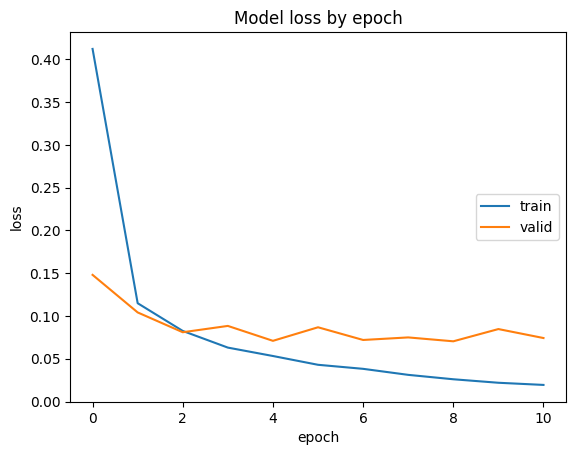

In [7]:
import matplotlib.pyplot as plt
# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()



**You should see that over-fitting begins to occur.**
 - **Question 1: WHAT IS THE SIGN OF OVER-FITTING ON ABOVE GRAPH?**

 - **Answer:**  the validation loss starts to increase while the training loss continues to decrease

**Question 2: Search into [Keras documentation](https://keras.io/api/) how to enforce early-stopping, implement the slight modification in code-cell below, re-run and observe result. At which iteration does training stop now?**


Epoch 1/11


/home/julyfun/miniconda3/envs/ml/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7512 - loss: 0.8169 - val_accuracy: 0.9542 - val_loss: 0.1564
Epoch 2/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9593 - loss: 0.1350 - val_accuracy: 0.9652 - val_loss: 0.1168
Epoch 3/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9709 - loss: 0.0956 - val_accuracy: 0.9692 - val_loss: 0.1011
Epoch 4/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9767 - loss: 0.0808 - val_accuracy: 0.9743 - val_loss: 0.0844
Epoch 5/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9796 - loss: 0.0647 - val_accuracy: 0.9750 - val_loss: 0.0847
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9729 - loss: 0.0859
The final loss on the TEST set is: 0.073.
The final compile_metrics on the TEST set is: 0.977.


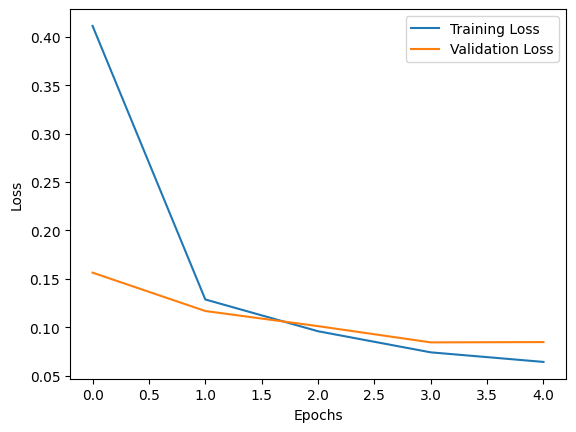

Training stopped at epoch: 5


In [12]:
# Paste here code for training modified to enforce early-stopping, + visualize new training curves
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

model = Sequential()
model.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='relu', data_format="channels_last", input_shape=( 28, 28, 1)) )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) )
model.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='relu') )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) )
model.add( Flatten() )
model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
model.add( Dropout(drop_prob_2) )
model.add( Dense(num_classes, activation='softmax') )

early_stopping = EarlyStopping(monitor='val_loss', patience=0.01, restore_best_weights=True)
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.7, callbacks=[early_stopping]) # ...holding out 70% of the data for validation
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.3f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 打印训练停止的迭代次数
print(f"Training stopped at epoch: {len(history.history['loss'])}")


**In order to obtain better training result, *you need to be able to train during more iterations before over-fitting starts to occur*. It is therefore needed not only to detect overfitting for stopping, but to also use some method that can MITIGATE overfitting so that it does NOT occur, or at least after many more iterations.**

 - **Question 3: what are the 2 different methods that can be used to PREVENT over-fitting ?**
 - **Answer:** Use of L1 or L2 regularization and Use « Dropout » regularization.

**Test those 2 methods SEPARATELY below, by copy-pasting the original code, modifying it, and running it.**

Epoch 1/11


563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6953 - loss: 1.1922 - val_accuracy: 0.9452 - val_loss: 0.3229
Epoch 2/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9497 - loss: 0.2876 - val_accuracy: 0.9646 - val_loss: 0.2146
Epoch 3/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9632 - loss: 0.2017 - val_accuracy: 0.9693 - val_loss: 0.1759
Epoch 4/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9704 - loss: 0.1655 - val_accuracy: 0.9696 - val_loss: 0.1621
Epoch 5/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9731 - loss: 0.1470 - val_accuracy: 0.9743 - val_loss: 0.1420
Epoch 6/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9769 - loss: 0.1328 - val_accuracy: 0.9715 - val_loss: 0.1512
Epoch 7/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9773 - loss: 0.1231 - val_accuracy: 0.9742 - val_loss: 0.1402
Epoch 8/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9795 - loss: 0.1178 - val_accuracy: 0.9729 - val_

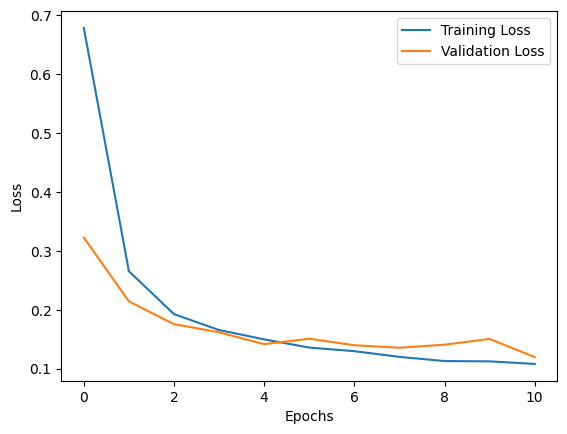

Training stopped at epoch: 11


In [22]:
# Test ConvNet overfitting prevention method #1
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
weight_penalty = 1e-2
model = Sequential()
model.add(Conv2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu', data_format="channels_last", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))
model.add(Conv2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))
model.add(Flatten())
model.add(Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)))
model.add(Dropout(drop_prob_2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.7)
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.3f}.'.format(loss_name, loss_value))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(f"Training stopped at epoch: {len(history.history['loss'])}")

Epoch 1/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4251 - loss: 1.6178 - val_accuracy: 0.9351 - val_loss: 0.2778
Epoch 2/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7972 - loss: 0.6073 - val_accuracy: 0.9540 - val_loss: 0.1718
Epoch 3/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8448 - loss: 0.4729 - val_accuracy: 0.9629 - val_loss: 0.1330
Epoch 4/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8677 - loss: 0.4042 - val_accuracy: 0.9666 - val_loss: 0.1109
Epoch 5/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8840 - loss: 0.3471 - val_accuracy: 0.9679 - val_loss: 0.1049
Epoch 6/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8910 - loss: 0.3304 - val_accuracy: 0.9704 - val_loss: 0.0990
Epoch 7/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8950 - loss: 0.3052 - val_accuracy: 0.9711 - val_loss: 0.0957
Epoch 8/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9014 - loss: 0.2971 - val_accuracy: 0.

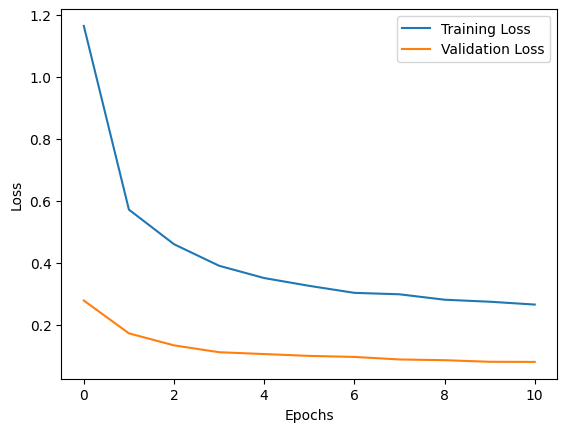

Training stopped at epoch: 11


In [24]:
#Test ConvNet overfitting prevention method #2
# Paste here code for training modified to enforce early-stopping, + visualize new training curves
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers

drop_prob_1 = 0.25
drop_prob_2 = 0.5
weight_penalty = 0  # L2 正则化系数
model = Sequential()
model.add(Conv2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu', data_format="channels_last", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))
model.add(Conv2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))
model.add(Flatten())
model.add(Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)))
model.add(Dropout(drop_prob_2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.7)
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.3f}.'.format(loss_name, loss_value))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(f"Training stopped at epoch: {len(history.history['loss'])}")

**FINAL ASSIGNMENT:**
**In code cell below, by applying a good combination and parameterization of the 2 regularization techniques, + increasing the number of training epochs, + reducing the proportion of validation hold-out, TRY TO OBTAIN >99% acuracy ON TEST SET:**

Epoch 1/34
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7449 - loss: 0.7727 - val_accuracy: 0.9707 - val_loss: 0.1022
Epoch 2/34
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9358 - loss: 0.2153 - val_accuracy: 0.9808 - val_loss: 0.0737
Epoch 3/34
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9539 - loss: 0.1605 - val_accuracy: 0.9805 - val_loss: 0.0702
Epoch 4/34
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9604 - loss: 0.1437 - val_accuracy: 0.9835 - val_loss: 0.0606
Epoch 5/34
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9635 - loss: 0.1274 - val_accuracy: 0.9867 - val_loss: 0.0560
Epoch 6/34
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9678 - loss: 0.1157 - val_accuracy: 0.9860 - val_loss: 0.0555
Epoch 7/34
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9696 - loss: 0.1124 - val_accuracy: 0.9873 - val_loss: 0.0555
Epoch 8/34
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9721 - loss: 0.1067 - 

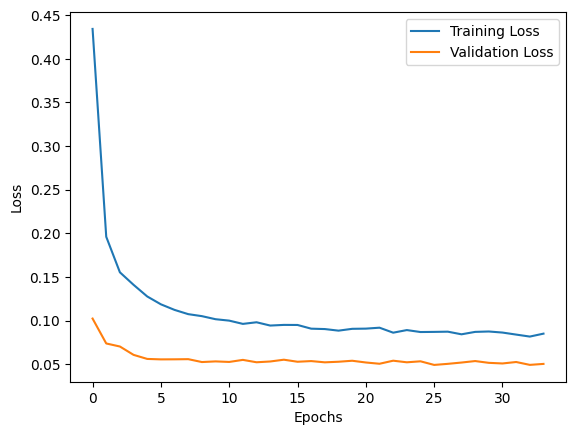

Training stopped at epoch: 34


In [46]:
#Test ConvNet overfitting prevention method #2
# Paste here code for training modified to enforce early-stopping, + visualize new training curves
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers

drop_prob_1 = 0.19
drop_prob_2 = 0.3
weight_penalty = 5e-5  # L2 正则化系数
num_epochs = 34    # we iterate num_epochs times over the entire training set

model = Sequential()
model.add(Conv2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu', data_format="channels_last", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))
model.add(Conv2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))
model.add(Flatten())
model.add(Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)))
model.add(Dropout(drop_prob_2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.2)
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.3f}.'.format(loss_name, loss_value))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(f"Training stopped at epoch: {len(history.history['loss'])}")


**OPTIONAL assignment:**
Test on your own examples: 1/ draw yourself by hand (for example in Microsoft Paint or equivalent image editor, or on paper that you photograph afterwards with your smartphone) a few examples for each class of handwritten digits; 2/ rescale and crop your images so that their size is 28x28 pixels with nearly no white borders around digits, and make sure they are saved as grayscale or even black-and-white; 3/ In the code cell below, load your images, plot them, and then feed each one into your best trained ConvNet and display for each one the class probabilities estimated by your ConvNet:

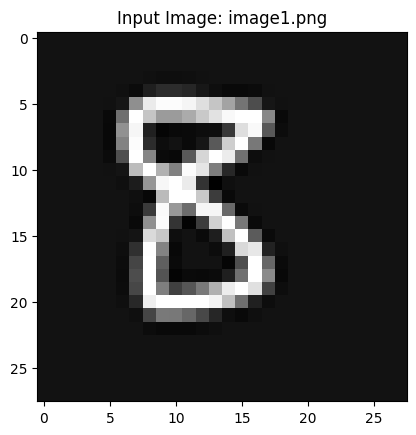

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predictions for image1.png:
Class 0: 0.0005
Class 1: 0.0000
Class 2: 0.0001
Class 3: 0.0051
Class 4: 0.0001
Class 5: 0.0099
Class 6: 0.0020
Class 7: 0.0000
Class 8: 0.9817
Class 9: 0.0007




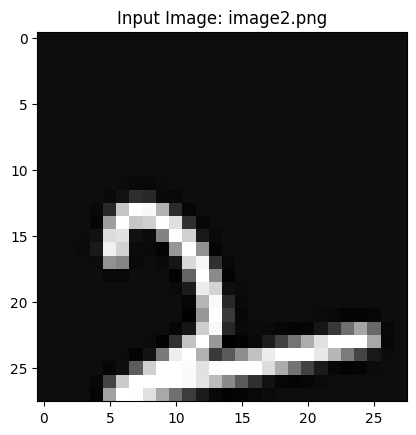

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predictions for image2.png:
Class 0: 0.1450
Class 1: 0.0651
Class 2: 0.5659
Class 3: 0.0106
Class 4: 0.0103
Class 5: 0.0027
Class 6: 0.0017
Class 7: 0.0277
Class 8: 0.1619
Class 9: 0.0092




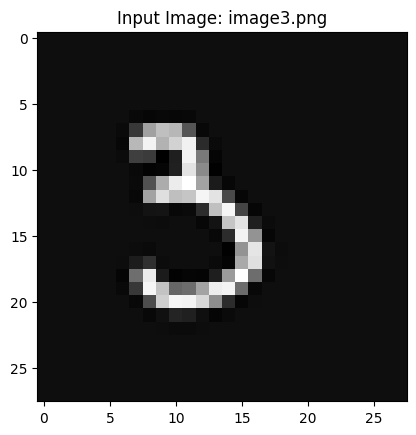

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predictions for image3.png:
Class 0: 0.0000
Class 1: 0.0003
Class 2: 0.0001
Class 3: 0.9545
Class 4: 0.0000
Class 5: 0.0426
Class 6: 0.0000
Class 7: 0.0002
Class 8: 0.0006
Class 9: 0.0017




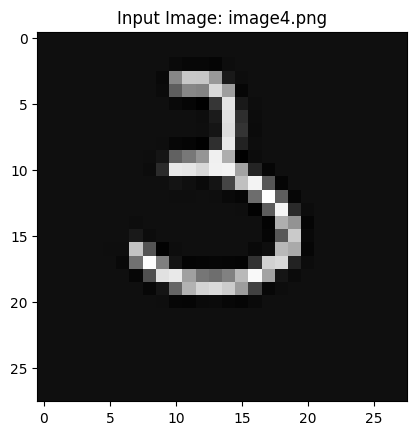

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predictions for image4.png:
Class 0: 0.0000
Class 1: 0.0006
Class 2: 0.0175
Class 3: 0.9748
Class 4: 0.0000
Class 5: 0.0013
Class 6: 0.0000
Class 7: 0.0016
Class 8: 0.0038
Class 9: 0.0004




In [47]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image

# 定义图像文件名
image_files = ['image1.png', 'image2.png', 'image3.png', 'image4.png']

# 预处理图像
def preprocess_image(img_path):
    img = Image.open(img_path).convert('L')  # 转换为灰度图像
    img = img.resize((28, 28))  # 调整大小为 28x28 像素
    img = np.array(img)  # 转换为 NumPy 数组
    img = img / 255.0  # 归一化
    img = img.reshape(1, 28, 28, 1)  # 调整形状以适应模型输入
    return img

# 加载和预测图像
for img_file in image_files:
    img = preprocess_image(img_file)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(f'Input Image: {img_file}')
    plt.show()
    
    # 预测类别概率
    predictions = model.predict(img)
    print(f'Predictions for {img_file}:')
    for i, prob in enumerate(predictions[0]):
        print(f'Class {i}: {prob:.4f}')
    print('\n')